# **CURSO: IRB2001 Fundamentos de la Robótica**

### Profesor: Daniel Florea
#### Ayudante: Jorge Apud

---

<div align='center'>
    <img width=55% src=https://www.maniskill.ai/imgs/home/image-ky-02.webp>
</div>

> En esta actividad exploraremos el aprendizaje por refuerzo en dos niveles de complejidad. Primero, trabajaremos con un simulador de péndulo invertido como ejemplo introductorio, programando un agente que implementa el algoritmo **Q-learning** en un entorno discreto. A través de este caso básico, analizaremos el funcionamiento de tablas Q, la política ε-greedy, el efecto de la función de recompensa y el rol de los hiperparámetros en el proceso de aprendizaje.  
>
> En una segunda parte, avanzaremos hacia un escenario más complejo utilizando **Proximal Policy Optimization (PPO)** para controlar un brazo robótico de 6 grados de libertad en la tarea de manipulación de objetos. Para esto utilizaremos el framework [ManiSkill](https://github.com/haosulab/ManiSkill), que nos permitirá trabajar con entornos realistas de robótica y aprovechar implementaciones avanzadas de algoritmos de aprendizaje por refuerzo.  

<small>Dentro de los objetivos de la actividad se encuentran:  

1. Comprender el funcionamiento del aprendizaje por refuerzo a través del caso básico del péndulo invertido.
2. Implementar y analizar un agente que aprende mediante Q-learning, evaluando el impacto de los hiperparámetros y la función de recompensa.  
3. Manipular un brazo robótico en un entorno simulado utilizando ManiSkill.
4. Entrenar un agente avanzado con el algoritmo PPO para realizar tareas de manipulación de objetos.
5. Reflexionar sobre las diferencias, desafíos y oportunidades al pasar de entornos simples con Q-learning a escenarios complejos con PPO en robótica.</small>  


Esta actividad se basa en códigos de ejemplo desarrollados por los equipos de [Gymnasium](https://gymnasium.farama.org/) y [ManiSkill](https://github.com/haosulab/ManiSkill). Se agradece y reconoce el trabajo de sus autores, cuyo aporte fue clave para construir esta implementación.


# **[IMPORTANTE]**

* *Para la ejecución de este cuaderno es necesario estar conectado a un entorno con GPU*

* Recuerda conectarte a un entorno con GPU (arriba a la derecha) **ANTES DE COMENZAR LA ACTIVIDAD** o si no perderas todas las variables de tu entorno al cambiarte.

* Algunas celdas en este cuaderno toman mucho tiempo en ejecutar (10-20 min) entonces realiza la actividad con tiempo, no la hagas a ultimo minuto.

---

# **Setup del entorno**
En las siguientes celdas se importaran las librerias y repositorios necesarias para el desarrollo de la actividad.

**Despues de correr la siguiente celda por primera vez es necesario reiniciar el entorno**

`Entorno de ejecución` >> `Reiniciar sesión`

In [1]:
%%capture
!pip install --quiet --upgrade mani_skill>=3.0.1 torch>=2.3 tensorboard wandb

La siguiente celda importa las librerias y descarga los archivos necesarios para el desarrollo de la actividad. Aqui se definen las variables del ambiente:

- env: variable del ambiente de simulación para la primera parte de la actividad.
- n_actions: acciones posibles para el ambiente de la primera parte de la actividad.

In [1]:
import os
import random
from collections import deque
from typing import Tuple, List, Sequence, Optional

import numpy as np
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt

# Para reproducir videos dentro de Colab
from IPython.display import HTML
import base64

from pathlib import Path
import subprocess
import time
from copy import deepcopy

def setup_env(env_id: str = "CartPole-v1", seed: int = 42, render_mode: Optional[str] = None):
    np.random.seed(seed)
    random.seed(seed)
    env = gym.make(env_id, render_mode=render_mode)
    env.reset(seed=seed)
    n_actions = env.action_space.n
    return env, n_actions

SEED = 42
ENV_ID = "CartPole-v1"

env, n_actions = setup_env(env_id=ENV_ID, seed=SEED, render_mode=None)

!wget https://raw.githubusercontent.com/haosulab/ManiSkill/main/examples/baselines/ppo/ppo.py -O ppo.py
!wget https://raw.githubusercontent.com/haosulab/ManiSkill/main/examples/baselines/ppo/ppo_rgb.py -O ppo_rgb.py

--2025-10-13 23:45:28--  https://raw.githubusercontent.com/haosulab/ManiSkill/main/examples/baselines/ppo/ppo.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22982 (22K) [text/plain]
Saving to: ‘ppo.py’

ppo.py              100%[===================>]  22.44K  --.-KB/s    in 0.001s  

2025-10-13 23:45:28 (18.6 MB/s) - ‘ppo.py’ saved [22982/22982]

--2025-10-13 23:45:28--  https://raw.githubusercontent.com/haosulab/ManiSkill/main/examples/baselines/ppo/ppo_rgb.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28267 (28K) [text/p

---

# **Implementación de Q-learning en CartPole (11 ptos.)**

Realizamos el set-up para entrenar un agente en el entorno clásico de péndulo invertido (CartPole).  
Esta implementación requiere 3 elementos principales:

1. Un entorno de simulación, en nuestro caso `CartPole-v1` de [Gymnasium](https://gymnasium.farama.org/), que nos entrega las observaciones y recompensas asociadas al comportamiento del sistema.  
2. Un agente basado en **Q-learning**, que utiliza una tabla Q y una política ε-greedy para balancear exploración y explotación en la selección de acciones.  
3. Un sistema de evaluación y visualización, que permite analizar el impacto de los hiperparámetros y de la función de recompensa en el desempeño del agente a lo largo de los episodios.  


## **(A1) Funciones basicas (2 ptos)**

Funciones miscelaneas necesarias para el desarrollo de la actividad.

#### 1.1 Creacion de bins (1 pto.)
Definimos una función que crea intervalos discretos para cada uno de los estados del pendulo, de esta manera podemos utilizar una Q-table discreta de los estados posibles.

Esta función recibe 3 listas:

- low: Lista del valor minimo de cada intervalo.
- high: Lista del valor maximo de cada intervalo.
- n_bins: Lista del numero de divisiones en el intervalo.

Retorna:
Una lista de los numpy arrays correspondientes a cada intervalo.

In [2]:
def create_bins(low: List, high: List, n_bins: List) -> List[np.ndarray]:
    bins = []
    for l, h, b in zip(low, high, n_bins):
        # Creamos b+1 bordes de intervalos entre low y high
        bins.append(np.linspace(l, h, b + 1))
    return bins
#Crea bins (bordes de intervalos) para discretizar cada dimensión del espacio de estados.

#### 1.2 Discretización del estado (1 pto.)

Definimos una función que toma un estado continuo y le asigna el intervalo correspondiente segun una lista de intervalos.

Esta función recibe:

- obs: Array de estados del robot.
- bins: Lista de arrays retornada por la función create_bins().
- clip_low: Array de los valores minimos admisibles para cada estado.
- clip_high: Array de los valores maximos admisibles para cada estado.

Retorna:
Una tupla con el indice correspondiente de cada estado al intervalo que le corresponde.

In [3]:

def discretize_state(obs: np.ndarray, bins: List[np.ndarray], clip_low: np.ndarray, clip_high: np.ndarray) -> Tuple[int, ...]:
    clipped = np.clip(obs, clip_low, clip_high)
    idxs = []
    for i, value in enumerate(clipped):
        # np.digitize retorna el índice del bin al que pertenece el valor
        idx = np.digitize(value, bins[i]) - 1  # -1 para que inicie desde 0
        idxs.append(idx)

    return tuple(idxs)
#Discretiza un estado continuo en índices de bins para cada dimensión.

#### Funciones de visualización y almacenamiento

Las siguientes funciones **no** deben ser modificadas, son para poder visualizar los datos y almacenar el Q-table final del entrenamiento.

La funcion save_q_table guarda un array de numpy para despues poder importar este valor en ves de tener que reentrenar al agente cada vez que se quiere realizar algun analisis, esto puede lograrse descargando este archivo y despues cargandolo con numpy.load(archivo).

In [4]:

def save_q_table(q_table: np.ndarray, path: str = "artifacts/Q_table_cartpole.npy"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    np.save(path, q_table)
    print(f"✅ Tabla Q guardada en: {path}")

def plot_learning_curves(returns, window=100, title_prefix="Q-Learning"):
    """
    Plots episode returns with a moving average overlay.
    """
    # Compute moving average
    mov = []
    q = deque(maxlen=window)
    for g in returns:
        q.append(g)
        mov.append(np.mean(q))

    # Plot both on the same figure
    plt.figure(figsize=(10, 5))
    plt.title(f"{title_prefix}: Retorno por episodio", fontsize=14, fontweight='bold')

    # Raw returns
    plt.plot(returns, color='mediumpurple', alpha=0.4, linewidth=1.5, label='Retorno por episodio')

    # Moving average
    plt.plot(mov, color='rebeccapurple', linewidth=2.5, label=f'Media móvil ({window})')

    # Labels and formatting
    plt.xlabel("Episodio", fontsize=12)
    plt.ylabel("Retorno", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(frameon=False, fontsize=11)
    plt.tight_layout()
    plt.show()

def record_greedy_episode_video(env_id: str, agent, max_steps: int = 500, seed: int = 123, video_folder: str = "videos", name_prefix: str = "qlearn_cartpole"):

    video_env = gym.make(env_id, render_mode="rgb_array")
    video_env = RecordVideo(video_env,
                            video_folder=video_folder,
                            name_prefix=name_prefix)
    obs, _ = video_env.reset(seed=seed)
    s = agent._state_to_idx(obs)
    total = 0.0

    for _ in range(max_steps):
        a = int(np.argmax(agent.Q[s]))
        obs, r, terminated, truncated, _ = video_env.step(a)
        s = agent._state_to_idx(obs)
        total += r
        if terminated or truncated:
            break

    video_env.close()
    print(f"🎥 Video grabado en ./{video_folder} (retorno={total:.1f})")
    return total

def play_video_colab(path: str):
    mp4 = open(path, "rb").read()
    data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
    return HTML(f"""<video width="640" height="480" controls>
      <source src="{data_url}" type="video/mp4">
      </video>""")


## **(A2) Clase Agente Q-learning (4 ptos.)**

Implementación de la clase del agente de aprendizaje reforzado.

#### 2.1 Función de recompensa / Reward function (1 pto.)

Definimos una función de recompensa para darle a nuestro agente, esta recibe 4 parametros:

- obs: Array del estado actual del robot
    - obs[0] = coordenada x del carro
    - obs[1] = velocidad x del carro
    - obs[2] = posicion angular del pendulo (angulo 0 es arriba)
    - obs[3] = velocidad angular del pendulo
- reward: Recompensa asignada por el ambiente al estado actual (+1 por cada paso completado, sea bueno o malo)
- terminated: Bool que indica si el robot falló en la tarea (Se cayó el pendulo o se alejo el carro de la pantalla), es verdadero si el robot falló y falso si el robot no ha fallado.
- truncated: Bool que indica que se acabó el tiempo de ejecución sin un fallo, es decir, el robot logró mantener el pendulo levantado y a si mismo dentro de la pantalla.

Debe retornar un float del valor de recompensa personalizado **definido por ti**, esta logica es lo que define como se comportará tu agente. Puedes decidir si premiarlo constantemente por acciones correctas, penalizarlo por salirse de un rango de operación, solo darle reward en casos terminales, o cualquier otra idea que se te ocurra. La desicion es **completamente libre**.

In [5]:
def custom_reward(obs: np.ndarray, reward: float, terminated: bool, truncated: bool) -> float:
    """
    Recompensa personalizada para el entorno CartPole.
    obs[0]: posición del carro (x)
    obs[1]: velocidad del carro
    obs[2]: ángulo del péndulo (0 = vertical)
    obs[3]: velocidad angular
    """
    # Recompensa base del entorno (+1 por paso sobrevivido)
    total_reward = reward

    # Factores máximos aproximados del entorno
    max_pos = 2.4     # Límite de la posición x del carro
    max_angle = 0.209 # ~12 grados en radianes (límite del ángulo permitido)

    # Penalizar desviaciones del centro y del ángulo
    pos_penalty = abs(obs[0]) / max_pos
    angle_penalty = abs(obs[2]) / max_angle

    # Usamos pesos para balancear importancia
    w_angle = 1.5   # mantener el péndulo vertical es lo más importante
    w_pos = 0.5     # no alejarse del centro

    # Recompensa por estar cerca del centro y del ángulo 0 (invertido: 1 - penalización)
    total_reward += (1 - angle_penalty) * w_angle
    total_reward += (1 - pos_penalty) * w_pos

    # Si el episodio termina por fallo, aplicamos gran penalización
    if terminated:
        total_reward -= 5.0

    return total_reward

#### 2.2 Agente (3 ptos.)

Definimos la clase **QLearningAgent**, esta define el comportamiento del controlador del robot, realiza el entrenamiento y la evaluación de una política.

Recibe como parámetros iniciales:

- **n_bins**: *Iterable* que define el número de intervalos para cada estado.  
- **n_actions**: *int* que describe el número de acciones posibles dentro del ambiente.  
- **alpha**: *float* del *learning rate* del agente.  
- **gamma**: *float* del factor de descuento de recompensas futuras en la actualización de Q.  
- **eps_start**: *float* del factor de exploración inicial.  
- **eps_end**: *float* del factor de exploración mínimo permitido durante el entrenamiento.  
- **eps_decay**: *float* factor con el que disminuye el factor de exploración en cada episodio de entrenamiento.  
- **reward_fn**: función de recompensa con la que evaluar cada estado.  

Además posee los atributos:

- **self._bins**: listas de bordes para discretizar cada dimensión del espacio de estados.  
- **self._clip_low**: límites inferiores para cada variable de estado, usados al discretizar.  
- **self._clip_high**: límites superiores para cada variable de estado, usados al discretizar.  
- **self.Q**: tabla Q de valores estado–acción, inicializada en ceros y actualizada durante el entrenamiento.  

Posee los métodos:

- **set_discretizer(self, bins, clip_low, clip_high):** configura la estrategia de discretización asignando los *bins* y límites de observación.  
- **_state_to_idx(self, obs):** convierte un estado continuo en un índice discreto utilizando los *bins* definidos.  
- **select_action(self, state_idx, explore=True):** selecciona una acción según la política ε-greedy, balanceando exploración y explotación.  
- **train_episode(self, env, max_steps=500):** ejecuta un episodio completo de entrenamiento, actualizando la tabla Q en cada paso, retornando la recompensa acumulada.  
- **eval_episode(self, env, max_steps=500):** ejecuta un episodio de evaluación (sin actualización de Q), retornando la recompensa acumulada.  
- **decay_epsilon(self):** reduce el valor de ε en cada episodio siguiendo la tasa de decaimiento definida.  


Debes completar los metodos:

- **select_action**

- **train_episode**

- **eval_episode**

- **decay_epsilon**

In [7]:

class QLearningAgent:
    def __init__(self, n_bins, n_actions: int, alpha: float = 0.1, gamma: float = 0.99, eps_start: float = 1.0,eps_end: float = 0.05, eps_decay: float = 0.999,reward_fn=None):
        self.n_bins = tuple(n_bins)
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.reward_fn = reward_fn

        self.Q = np.zeros((*self.n_bins, n_actions), dtype=np.float32)

        self._bins = None
        self._clip_low = None
        self._clip_high = None

    def set_discretizer(self, bins, clip_low, clip_high):
        self._bins = bins
        self._clip_low = np.array(clip_low, dtype=np.float32)
        self._clip_high = np.array(clip_high, dtype=np.float32)

    def _state_to_idx(self, obs):
        assert self._bins is not None, "Llama set_discretizer() antes de usar el agente."
        return discretize_state(obs, self._bins, self._clip_low, self._clip_high)

    def select_action(self, state_idx, explore=True):
        if explore and np.random.rand() < self.epsilon:
            # Exploración: acción aleatoria
            return np.random.randint(self.n_actions)
        else:
            # Explotación: mejor acción según Q
            return int(np.argmax(self.Q[state_idx]))

    def train_episode(self, env, max_steps: int = 500) -> float:
        obs, _ = env.reset()
        s = self._state_to_idx(obs)
        G = 0.0

        for _ in range(max_steps):
            a = self.select_action(s, explore=True)
            next_obs, r, terminated, truncated, _ = env.step(a)

            # Aplicar función de recompensa personalizada si existe
            if self.reward_fn:
                reward = self.reward_fn(next_obs, r, terminated, truncated)
            else:
                reward = r


            s2 = self._state_to_idx(next_obs)

            # Actualización Q-learning
            # Q(s,a) = Q(s,a) + alpha * [reward + gamma * max_a' Q(s2,a') - Q(s,a)]
            best_next = np.max(self.Q[s2])
            td_target = reward + self.gamma * best_next
            self.Q[s][a] += self.alpha * (td_target - self.Q[s][a])

            G += reward
            s = s2
            if terminated or truncated:
                break
        return G

    def eval_episode(self, env, max_steps: int = 500) -> float:
        obs, _ = env.reset()
        s = self._state_to_idx(obs)
        G = 0.0

        for _ in range(max_steps):
            a = self.select_action(s, explore=False)
            obs, r, terminated, truncated, _ = env.step(a)

            if self.reward_fn:
                reward = self.reward_fn(obs, r, terminated, truncated)
            else:
                reward = r

            s = self._state_to_idx(obs)
            G += reward
            if terminated or truncated:
                break
        return G

    def decay_epsilon(self):
         self.epsilon = max(self.eps_end, self.epsilon * self.eps_decay)

## **(A3) Entrenamiento agente (3 ptos.)**

Aqui se realiza el entrenamiento del agente utilizando las funciones y clase definidas anteriormente.

### 3.1 Creacion bins (0.5 ptos.)

Se generan los bins utilizando la función del item **1.1**, defina las variables N_BINS, OBS_CLIP_LOW y OBS_CLIP_HIGH con valores razonables.


In [8]:
N_BINS = (6, 6, 12, 6)

OBS_CLIP_LOW = np.array([-4.8, -3.0, -0.418, -4.0])
OBS_CLIP_HIGH = np.array([4.8, 3.0, 0.418, 4.0])

# Crear bins
bins = create_bins(OBS_CLIP_LOW, OBS_CLIP_HIGH, N_BINS)

### 3.2 Instancia agente (0.5 ptos.)

Se genera la instancia del agente de la clase QLearningAgent, defina los parametros del agente con valores razonables. Llame tambien al metodo para generar los intervalos discretos para los estados.



In [9]:

N_EPISODES     = 5000   # número de episodios de entrenamiento
MAX_STEPS      = 500    # pasos máximos por episodio
GAMMA          = 0.99   # descuento de recompensas futuras
ALPHA          = 0.1    # learning rate
EPS_START      = 1.0    # epsilon inicial (exploración total)
EPS_END        = 0.05   # epsilon mínimo
EPS_DECAY      = 0.995  # factor de decaimiento de epsilon

agent = QLearningAgent(
    n_bins=N_BINS,
    n_actions=n_actions,
    alpha=ALPHA,
    gamma=GAMMA,
    eps_start=EPS_START,
    eps_end=EPS_END,
    eps_decay=EPS_DECAY,
    reward_fn=custom_reward  # usamos nuestra recompensa personalizada
)

# Configurar discretizador del estado
agent.set_discretizer(bins, OBS_CLIP_LOW, OBS_CLIP_HIGH)



### 3.3 Entrenamiento agente (2 ptos.)

Se realiza el flujo de codigo para generar el entrenamiento completo del agente.

En este se deben utilizar el metodo para realizar un episodio de entrenamiento segun el numero de iteraciones que se quiere entrenar, se debe añadir los rewards de entrenamiento a la lista returns para poder graficar el desempeño a lo largo del periodo de evaluación y se debe realizar el decaimiento del valor de epsilon.

Aqui tambien se implementa un metodo de detención temprana si es que el promedio del reward de las ultimas iteraciones supera un cierto umbral, esto detiene el entrenamiento si es que el agente llega a un cierto desempeño.

Se deben definir los parametros:
- EVAL_EVERY: Cada cuantos episodios de entrenamiento generar una evaluación para presentar metricas actuales.
- EVAL_EPISODES: Cuantos episodios de evaluación genera en cada instancia de evaluación.
- TARGET_RETURN: El umbral de reward promedio con el que detener el entrenamiento.
- MA_WINDOW: Numero de episodios sobre los cuales se toma el promedio movil de los datos (Moving average window).

Decide el valor de TARGET_RETURN segun los valores que retorna tu función de recompensa (una regla de simple puede ser calcular el valor del reward si el agente actua de manera correcta un X% del total de pasos)

In [10]:
EVAL_EVERY     = 100     # Evaluar cada 100 episodios
EVAL_EPISODES  = 10      # En cada evaluación, correr 10 episodios sin aprendizaje
TARGET_RETURN  = 180     # Si promedio móvil >= 180, se considera buen desempeño
MA_WINDOW      = 100     # Ventana de 100 episodios para promedio móvil

returns = []
best_eval = -np.inf

for ep in range(1, N_EPISODES + 1):
    # EPISODIO DE ENTRENAMIENTO
    G = agent.train_episode(env, max_steps=MAX_STEPS)
    returns.append(G)

    # Decaer epsilon
    agent.epsilon = max(agent.eps_end, agent.epsilon * agent.eps_decay)

    # Evaluación periódica (sin aprendizaje)
    if ep % EVAL_EVERY == 0 or ep == 1:
        eval_scores = []
        for _ in range(EVAL_EPISODES):
            eval_scores.append(agent.eval_episode(env, max_steps=MAX_STEPS))

        mean_eval = float(np.mean(eval_scores))
        std_eval  = float(np.std(eval_scores))
        best_eval = max(best_eval, mean_eval)

        print(f"[Ep {ep:6d}] Train G={G:6.1f} | Eval mean={mean_eval:6.1f}±{std_eval:5.1f} | eps={agent.epsilon:.3f}")

    # Parada temprana opcional usando media móvil
    if len(returns) >= MA_WINDOW and np.mean(returns[-MA_WINDOW:]) >= TARGET_RETURN:
        print(f"✅ Criterio alcanzado: media móvil ≥ {TARGET_RETURN} en ep {ep}.")
        break

save_q_table(agent.Q, path="artifacts/Q_table_cartpole.npy")

[Ep      1] Train G=  60.5 | Eval mean=  35.4± 15.0 | eps=0.995
[Ep    100] Train G=  32.3 | Eval mean= 153.8±188.5 | eps=0.606
[Ep    200] Train G=  62.7 | Eval mean= 119.8±114.3 | eps=0.367
✅ Criterio alcanzado: media móvil ≥ 180 en ep 281.
✅ Tabla Q guardada en: artifacts/Q_table_cartpole.npy


## **(A4) Visualización metricas (1 pto.)**

Graficamos la evolución del aprendizaje de su agente utilizando las funciones definidas previamente.

Reporta el valor de reward promedio final en un episodio de evaluación junto con su desviación estandar (media ± desviación estandar).

Comenta sobre los graficos y el valor final de reward, que tendencias puede observar en cada uno de los graficos.

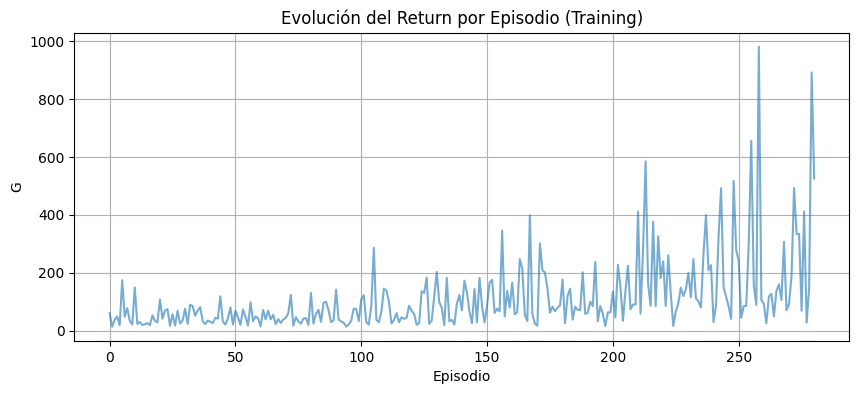

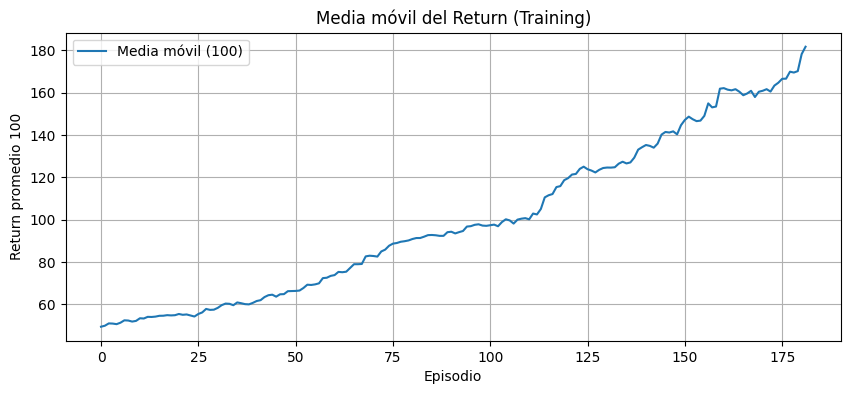

Evaluación final: media=277.8 ± 112.2 (n=5)


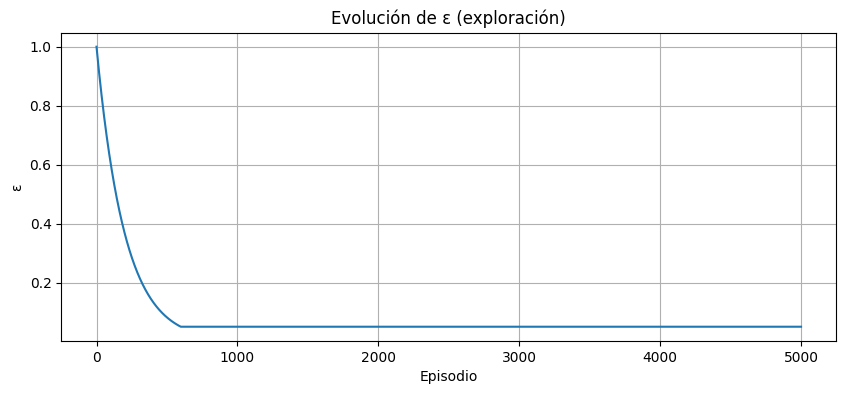

In [11]:
#GRAFICOS DE ENTRENAMIENTO

# 1.Gráfico de retornos por episodio
plt.figure(figsize=(10,4))
plt.plot(returns, alpha=0.6)
plt.title("Evolución del Return por Episodio (Training)")
plt.xlabel("Episodio")
plt.ylabel("G")
plt.grid(True)
plt.show()

# 2.Gráfico de media móvil (suavizado)
window = MA_WINDOW
if len(returns) >= window:
    ma = np.convolve(returns, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(10,4))
    plt.plot(ma, label=f"Media móvil ({window})")
    plt.title("Media móvil del Return (Training)")
    plt.xlabel("Episodio")
    plt.ylabel(f"Return promedio {window}")
    plt.grid(True)
    plt.legend()
    plt.show()

# 3.Gráfico de epsilon (exploración)
eps_values = []
eps_temp = EPS_START
for _ in range(N_EPISODES):
    eps_values.append(eps_temp)
    eps_temp = max(EPS_END, eps_temp * EPS_DECAY)

plt.figure(figsize=(10,4))
plt.plot(eps_values)
plt.title("Evolución de ε (exploración)")
plt.xlabel("Episodio")
plt.ylabel("ε")
plt.grid(True)

final_scores = []
for _ in range(5):
    final_scores.append(agent.eval_episode(env, max_steps=MAX_STEPS))
print(f"Evaluación final: media={np.mean(final_scores):.1f} ± {np.std(final_scores):.1f} (n=5)")

Return por episodio: Al principio, los retornos son bajos y muy cambiantes porque el agente prueba acciones al azar. Con el tiempo, algunos episodios muestran valores mucho más altos, lo que indica que el agente empieza a aprender buenas estrategias. En general, los resultados tienden a mejorar conforme avanza el entrenamiento.

Media móvil del Return: La media móvil ayuda a ver la tendencia sin tanto ruido. Se observa un aumento constante hasta valores más altos, mostrando que el desempeño promedio del agente está mejorando y que la política se está estabilizando. Los primeros episodios son importantes para que el agente aprenda la base de la estrategia.

Evolución de ε (exploración): Al inicio, ε es 1.0, lo que hace que el agente explore mucho. Luego disminuye poco a poco hasta cerca de 0.05, permitiendo que el agente use más lo que ha aprendido. Esto refleja que primero se explora y después se aprovechan las mejores acciones.



## **(A5) Visualización agente (1pto.)**

Se graba y muestra un video del agente funcionando para 2 condiciones iniciales distintas para ver como se comporta el agente.


In [ ]:
# == COMPLETAR ==

¿Que comportamientos puedes observar en tu agente? ¿Cuales crees que son buenos y cuales crees que son malos? ¿Como podrias modificar tu función de reward para promover los comportamientos buenos y penalizar los malos?

---

*(Rellena con tu respuesta aqui)*



---

# **Implementación proximal policy optimization con ManiSkill (10 ptos.)**

> En esta segunda parte trabajaremos con el simulador [ManiSkill](https://github.com/haosulab/ManiSkill) para entrenar políticas de control sobre brazos roboticos. Utilizando paralelización en GPU para acelerar el aprendizaje.

El algoritmo de proximal policy optimization al ser más complejo que Q-learning requiere archivos de implementación más avanzados, por esto mismo la implementación que realizaremos ahora es una manera de ejecutar estos archivos desde colab.

En las siguientes secciones abordaremos los escenarios `PushCube-v1` y `PullCube-v1` en dos modalidades de observación:
- **Representación por estado.** (archivo `ppo.py`)
- **Representación visual RGB.** (archivo `ppo_rgb.py`)

---
## **(A6) Configuración base y utilidades (3 ptos.)**

Definimos funciones auxiliares y parametros para lanzar entrenamientos y evaluaciones desde el notebook.


Creamos una carpeta donde guardar los resultados.

In [ ]:
# Carpeta donde "ppo.py" y "ppo_rgb.py" guardan resultados
RUNS_DIR = Path("runs")
RUNS_DIR.mkdir(exist_ok=True)

#### 6.1 Diccionario a CLI (1 pto.)
Definimos una función que transforma un diccionario a un lista de argumentos para comandos de linea de terminal (CLI).

Esta recibe un diccionario y debe retornar una lista de la forma:

["--argumento_1=valor_1", "--argumento_2=valor_2", ...]

In [ ]:
def dict_to_cli(args_dict):
    cli_args = []
    # == COMPLETAR ==
    return cli_args

#### 6.2 Funcion de entrenamiento (1 pto.)

Definimos una funcion que ejecuta los archivos de entrenamiento mediante comandos de terminal.

Esta recibe:

- script_name: string del nombre del archivo a ejecutar.
- env_id: string del ambiente en el cual realizar el entrenamiento.
- exp_name: string de la experiencia que se va a realizar.
- base_args: diccionario de los argumentos a utilizar para ejecutar el script.
- extra_args: diccionario con argumentos extra, utilizado para poder aprovechar esta misma función para evaluación.

Retorna el resultado del entrenamiento.

In [ ]:
def run_training(script_name: str, env_id: str, exp_name: str, base_args: dict, extra_args=None):
    args = [f'--env-id={env_id}', f'--exp-name={exp_name}']

    args = None # == COMPLETAR ==

    cmd = ['python', script_name, *args]
    print('Ejecutando:', ' '.join(cmd))
    start = time.time()
    process = subprocess.run(cmd, check=False)
    elapsed = (time.time() - start) / 60
    status = 'OK' if process.returncode == 0 else f'Error (código {process.returncode})'
    print(f'{status} · Duración aproximada: {elapsed:.1f} min')
    return process.returncode

#### 6.3 Funcion de evaluación. (1 pto.)

Definimos una funcion que ejecuta una evaluación de un modelo entrenado mediante comandos de terminal.

Esta recibe:

- script_name: string del nombre del archivo a ejecutar.
- env_id: string del ambiente en el cual realizar la evaluación.
- exp_name: string de la experiencia que se va a realizar.
- checkpoint_path: Path de la ubicación del modelo a evaluar.
- eval_args: diccionario de los argumentos que debe entregar a la funcion run_training.

Retorna el resultado del entrenamiento.

In [ ]:
def run_evaluation(script_name: str, env_id: str, exp_name: str, checkpoint_path, eval_args: dict):
    args = deepcopy(eval_args)

    checkpoint = Path(checkpoint_path)
    if not checkpoint.exists():
        raise FileNotFoundError(f'No se encontró el checkpoint en {checkpoint}. Ajusta la ruta manualmente.')

    extra_flags = ['--evaluate', f'--checkpoint={checkpoint.as_posix()}']
    return # == COMPLETAR ==


---
## **(A7) Entrenamiento PPO con observaciones de estado (2 ptos.)**

Entrenamos primero utilizando la representación vectorial (`obs_mode="state"`).


### 7.1 PushCube · Estado (1 pto.)

Definimos el diccionario STATE_TRAINING_ARGS con los parametros:

- num_envs: numero de ambientes a simular en paralelo (ten cuidado de no hacer este numero muy grande para no llenar la memoria de la GPU)
- update_epochs: número de pasadas que hace PPO sobre la misma colección de datos antes de recolectar una trayectoria nueva; más épocas implican más pasos de optimización por batch
- num_minibatches: cuántos minibatches se generan a partir del lote completo en cada epoch; controla el tamaño de cada actualización de gradiente.
- total_timesteps: cantidad total de pasos de simulación que se ejecutarán a lo largo de todo el entrenamiento; define la duración global del experimento.
- eval_freq: cada cuántos ciclos de entrenamiento se corre una evaluación del agente (en pasos de actualización); sirve para monitorear el desempeño.
- num_steps: número de pasos que cada entorno acumula antes de detener el rollout y pasar a la fase de optimización; fija la longitud de las trayectorias recabadas en cada iteración.


In [ ]:
STATE_TRAINING_ARGS = {
    "num_envs": None, # == COMPLETAR ==
    "update_epochs": None, # == COMPLETAR ==
    "num_minibatches": None, # == COMPLETAR ==
    "total_timesteps": None, # == COMPLETAR ==
    "eval_freq": None, # == COMPLETAR ==
    "num_steps": None # == COMPLETAR ==
}

Ejecutamos el entrenamiento con los parametros definidos en la celda anterior, ppo basado en estados, el ambiente "PushCube-v1" y el nombre de experiencia "state-pushcube".

In [ ]:
# == COMPLETAR ==

### 7.2 PullCube · Estado (1 pto.)

Ejecutamos el entrenamiento de la misma manera que para el caso anterior pero se cambia el ambiente a "PullCube-v1" y el nombre de la experiencia a "state-pullcube".

In [ ]:
# == COMPLETAR ==

---
## **(A8) Entrenamiento PPO con observaciones visuales (2 ptos.)**

Para esta etapa utilizamos el script `ppo_rgb.py`, que define una política con convoluciones para procesar imágenes.


### 8.1 PushCube · RGB (1 pto.)

Definimos el diccionario RGB_TRAINING_ARGS con los mismos parametros que STATE_TRAINING_ARGS, define los valores considerando que este entrenamiento es más pesado y que utiliza más recursos, ademas converge más lento que el caso basado en estados.


In [ ]:
RGB_TRAINING_ARGS = {
    "num_envs": None, # == COMPLETAR ==
    "update_epochs": None, # == COMPLETAR ==
    "num_minibatches": None, # == COMPLETAR ==
    "total_timesteps": None, # == COMPLETAR ==
    "eval_freq": None, # == COMPLETAR ==
    "num_steps": None # == COMPLETAR ==
}

Ejecutamos el entrenamiento con los parametros definidos en la celda anterior, ppo basado en visualización, el ambiente "PushCube-v1" y el nombre de experiencia "rgb-pushcube".

In [ ]:
# == COMPLETAR ==

### 8.2 PullCube · RGB (1 pto.)

Ejecutamos el entrenamiento de la misma manera que para el caso anterior pero se cambia el ambiente a "PullCube-v1" y el nombre de la experiencia a "state-pullcube".


In [ ]:
# == COMPLETAR ==

---
## **(A9) Visualización de resultados (1 pto.)**



### 9.1 Evaluación de políticas entrenadas (1 pto.)

Ejecutamos un ciclo de evaluación sobre un checkpoint entrenado y guardamos los videos en `runs/<experimento>/test_videos/`.

Definimos el diccionario EVALUATION_ARGS que incluye los parametros:
- num_envs: int numero de ambientes simulados en paralelo, no utilices un numero muy grande para poder ver todos los videos en paralelo.
- num_steps: int numero de pasos que se ejecutan en cada ambiente.
- num_eval_envs:


Aqui debes utilizar la función de evaluación para 2 experiencias distintas, para esto debes definir la ruta del CHECKPOINT_PATH para 2 entrenamientos.

(Revisa los archivos de colab a mano izquierda, en `runs/experimento/final_ckpt.pt` estan la version final del entrenamiento para cada experimento)

In [ ]:

EVALUATION_ARGS = {
    'num_envs': None, # == COMPLETAR ==
    'num_steps': None, # == COMPLETAR ==
    'num_eval_envs': None # == COMPLETAR ==
}


CHECKPOINT_PATH = Path() # == COMPLETAR ==
id = CHECKPOINT_PATH.as_posix().split('/')[1]

if 'state' in id:
  script = "ppo.py"
  if "pushcube" in id:
    envid = "PushCube-v1"
    exp = "state-pushcube"
  else:
    envid = "PullCube-v1"
    exp = "state-pullcube"
else:
  script = "ppo_rgb.py"
  if "pushcube" in id:
    envid = "PushCube-v1"
    exp = "rgb-pushcube"
  else:
    envid = "PullCube-v1"
    exp = "rgb-pullcube"

# == COMPLETAR ==


CHECKPOINT_PATH2 = Path() # == COMPLETAR ==
id2 = CHECKPOINT_PATH2.as_posix().split('/')[1]

if 'state' in id2:
  script2 = "ppo.py"
  if "pushcube" in id2:
    envid2 = "PushCube-v1"
    exp2 = "state-pushcube"
  else:
    envid2 = "PullCube-v1"
    exp2 = "state-pullcube"
else:
  script2 = "ppo_rgb.py"
  if "pushcube" in id2:
    envid2 = "PushCube-v1"
    exp2 = "rgb-pushcube"
  else:
    envid = "PullCube-v1"
    exp2 = "rgb-pullcube"

# == COMPLETAR ==

Visualizamos el video utilizando la función definida en la primera parte de la actividad.

In [ ]:
# == COMPLETAR ==

In [ ]:
# == COMPLETAR ==

### 9.2 Metricas con tensorboard.
Utilizamos TensorBoard para revisar las métricas almacenadas en la carpeta `runs/`.

No es necesario cambiar nada de la siguiente celda.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs --port 6006

---
## **(A10) Analisis PPO (2 pto.)**

Responde las siguientes preguntas en la proxima celda:

- ¿Cómo cambia la velocidad de convergencia entre observaciones por estado y RGB?
- ¿Qué diferencias observas en la calidad de las trayectorias generadas?
- ¿Que ventajas ves de utilizar la paralelización por GPU al entrenar estos casos, que ventajas podria tener esto para aplicaciones reales?.
- ¿Para que caso crees que conviene utilizar entrenamiento por estado y en que caso conviene RGB?


---

*(Rellena con tu respuesta aqui)*


---